## Setting up environment

In [17]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor

## Data Simulation

In [2]:
np.random.seed(42)
n=1000   #number of observations, reduced to 1000 for faster runtime
p=10   #number of X covariates, reduced to 10 for faster runtime
X_matrix = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float') #X covariates matrix
T = np.random.binomial(1, 0.5, n).astype('int') #treatment groups randomly assigned
X_cols = ['X' + str(x) for x in range(1,(p+1))] #X1, X2, ..., X100
df = pd.DataFrame(X_matrix, columns = X_cols) #store into a dataframe
b = 10*np.sin(np.pi*df['X1']*df['X2'] ) + 20*(df['X3']-0.5)**2 + 10*df['X4'] + 5*df['X5'] #Friedman function (non-linear)
tau = df['X1'] + np.log(1 + np.exp(df['X2'])) #treatment effect (non-constant)
u = np.random.normal(0, 25, n) #random error component ui
Y = (b + T*tau + u).astype('float') #outcome variable Yi
df['T'] = T
df['Y'] = Y

## Build MLRATE Function

In [3]:
def mlrate(data, X_columns, y, T, model, tau, n_splits=2, alpha=0.05, random_seed=42):
    #k-fold split suggested in paper, default to k=2
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    idx = []
    Y_hat = []
    for train_index, test_index in kfold.split(data, data[T]):

        df_train = data.iloc[train_index].reset_index()
        df_test = data.iloc[test_index].reset_index()

        X_train = df_train[X_columns].copy()
        y_train = df_train[y].copy()
        X_test =  df_test[X_columns].copy()
        model.fit(X_train, y_train)
        #predict Yi with our model
        y_pred = model.predict(X_test)

        idx.extend(test_index)
        Y_hat.extend(list(y_pred))

    df_res = pd.DataFrame({'index':idx,'Yhat':Y_hat}).sort_values(by='index').reset_index(drop=True)
    df_res[['Y','T']] = data[[y, T]]
    df_res['Yhat_dev'] = df_res['Yhat'] - np.mean(df_res['Yhat']) #difference between Y hat and mean of Y hat
    df_res['Yhat_T'] = df_res['T'] * df_res['Yhat_dev']
    df_res.drop('index', axis=1, inplace=True)
    #fit ols model and compute treatment effect as OLS estimator of coefficient for T
    ols_reg = smf.ols('Y ~ T + Yhat + Yhat_T', data = df_res).fit()
    ate = ols_reg.params['T']
    std = ols_reg.bse['T']
    z = norm.ppf(1-alpha/2)
    #upper and lower bound for 100(1-a)% CI
    upper = ate+z*std
    lower = ate-z*std
    coverage = sum((tau>=lower) & (tau<=upper)) / len(tau)
    return ate, std, lower, upper, coverage

In [4]:
#trying our algorithm with XGBoost
XGB_reg = XGBRegressor()
mlrate(df, X_columns=X_cols, y='Y', T='T', model=XGB_reg, tau=tau)[0] #ate

3.022302266871943

In [5]:
mlrate(df, X_columns=X_cols, y='Y', T='T', model=XGB_reg, tau=tau)[4] #coverage

0.916

In [6]:
def diff_in_mean(data, X_columns, y, T, tau, alpha=0.05):
  df_t = data[data[T] == 1].copy()
  df_c = data[data[T] == 0].copy()
  #difference in mean
  u_diff = np.mean(df_t[y]) - np.mean(df_c[y])

  #calculate the standard error
  s1_sq = np.var(df_t[y], ddof=1)
  s2_sq = np.var(df_c[y], ddof=1)
  n1 = len(df_t)
  n2 = len(df_c)
  std = np.sqrt(((n1-1)*s1_sq+(n2-1)*s2_sq)/(n1+n2-2)) * np.sqrt(1/n1 + 1/n2)
  z = norm.ppf(1-alpha/2)
  #upper and lower bound for 100(1-a)% CI
  upper = u_diff+z*std
  lower = u_diff-z*std
  coverage = sum((tau>=lower) & (tau<=upper)) / len(tau)
  return u_diff, std, lower, upper, coverage

#testing
diff_in_mean(df, X_cols, 'Y', 'T', tau)

(4.863509074749235,
 2.6817933417283624,
 -0.3927092890176729,
 10.119727438516144,
 0.868)

## Bootstrap and plotting
Since our treatment effect is non-constant, here we do not plot a distribution plot of ATE against the true ATE. Rather, we plot the cumulative average of coverages and interval widths from the confidence intervals in our bootstrapping process.

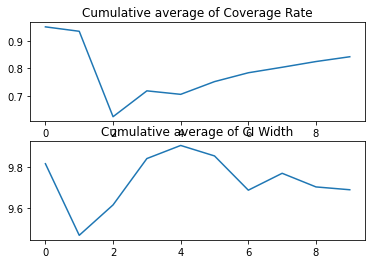

<Figure size 720x432 with 0 Axes>

Average Coverage Rate is 0.8421, and Average CI Width is 9.689405542797328


In [9]:
#bootstrap and calculate running average of coverage rate

#initiate ML model for predicting Yi
XGB_reg = XGBRegressor()

#choose number of bootstraps and bootstrap size
B = 10
b_size = 500
std_values = np.zeros(B)
coverage_values = np.zeros(B)
width_values = np.zeros(B)
for b in range(B):
    boot_sample = df.sample(n = b_size, replace = True, random_state = b+1).reset_index(drop=True)
    result = mlrate(boot_sample, X_columns=X_cols, y='Y', T='T', model=XGB_reg, tau=tau, random_seed=b+1)
    std = result[1]
    coverage = result[4]
    width = result[3] - result[2]
    std_values[b] = std
    coverage_values[b] = coverage
    width_values[b] = width

#plotting the cumulative average of std, coverage rate, and interval width
i = 1
cov_ma = []
wid_ma = []
cov_cs = np.cumsum(coverage_values)
wid_cs = np.cumsum(width_values);
while i <= B:
    cov_wa = cov_cs[i-1] / i
    wid_wa = wid_cs[i-1] / i
    cov_ma.append(cov_wa)
    wid_ma.append(wid_wa)
    i += 1

figure, axis = plt.subplots(2,1)

#plot coverage
axis[0].plot(list(range(B)), cov_ma)
axis[0].set_title("Cumulative average of Coverage Rate")
#plot interval width
axis[1].plot(list(range(B)), wid_ma)
axis[1].set_title("Cumulative average of CI Width")

plt.figure(figsize=(10,6))
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

print(f'Average Coverage Rate is {cov_ma[-1]}, and Average CI Width is {wid_ma[-1]}')

In [10]:
def bootstrap(method, B, b_size, data, X_columns, y, T, model, tau):
    std_values = np.zeros(B)
    coverage_values = np.zeros(B)
    width_values = np.zeros(B)
    for b in range(B):
        boot_sample = data.sample(n = b_size, replace = True, random_state = b+1).reset_index(drop=True)
        if method == "mlrate":
            result = mlrate(boot_sample, X_columns=X_columns, y=y, T=T, model=model, tau=tau, random_seed=b+1)
        if method == "dim":
            result = diff_in_mean(boot_sample, X_columns=X_columns, y=y, T=T, tau=tau)
        std = result[1]
        coverage = result[4]
        width = result[3] - result[2]
        std_values[b] = std
        coverage_values[b] = coverage
        width_values[b] = width
    return std_values, coverage_values, width_values

In [11]:
result_ml = bootstrap(method="mlrate", B=200, b_size=500, data=df, X_columns=X_cols, y='Y', T='T', model=XGB_reg, tau=tau)
std_ml = result_ml[0]
coverage_ml = result_ml[1]
width_ml = result_ml[2]

In [12]:
result_di = bootstrap(method="dim", B=200, b_size=500, data=df, X_columns=X_cols, y='Y', T='T', model=XGB_reg, tau=tau)
std_di = result_di[0]
coverage_di = result_di[1]
width_di = result_di[2]

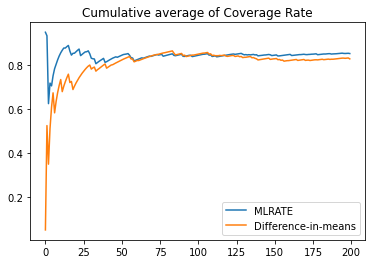

Average Coverage Rate of MLRATE is 0.8532150000000001, Difference in Means is 0.828995


In [13]:
final_results = pd.DataFrame(data={'std_ml': std_ml, 'coverage_ml': coverage_ml, 'width_ml': width_ml,
                                   'std_dim': std_di, 'coverage_dim': coverage_di, 'width_dim': width_di})
cov_ma_ml = np.array(final_results['coverage_ml'].expanding().mean())
wid_ma_ml = np.array(final_results['width_ml'].expanding().mean())
cov_ma_dim = np.array(final_results['coverage_dim'].expanding().mean())
wid_ma_dim = np.array(final_results['width_dim'].expanding().mean())

#plot coverage
plt.plot(list(range(200)), cov_ma_ml, label='MLRATE')
plt.plot(list(range(200)), cov_ma_dim, label='Difference-in-means')
plt.title("Cumulative average of Coverage Rate")

plt.legend()
plt.show()

print(f'Average Coverage Rate of MLRATE is {cov_ma_ml[-1]}, Difference in Means is {cov_ma_dim[-1]}')

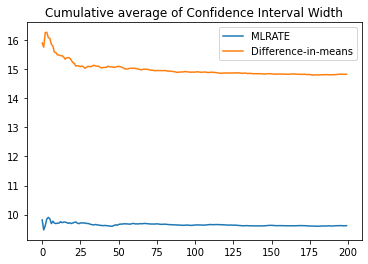

Average CI Width of MLRATE is 9.616552613517465, Difference in Means is 14.83691251395897


In [14]:
#plot interval width
plt.plot(list(range(200)), wid_ma_ml, label="MLRATE")
plt.plot(list(range(200)), wid_ma_dim, label="Difference-in-means")
plt.title("Cumulative average of Confidence Interval Width")

plt.legend()
plt.show()

print(f'Average CI Width of MLRATE is {wid_ma_ml[-1]}, Difference in Means is {wid_ma_dim[-1]}')

In [15]:
(wid_ma_ml[-1]-wid_ma_dim[-1])/wid_ma_dim[-1]

-0.3518494764682375

Average Standard Error of MLRATE is 2.453247276320281, Difference in Means is 3.784996211917832


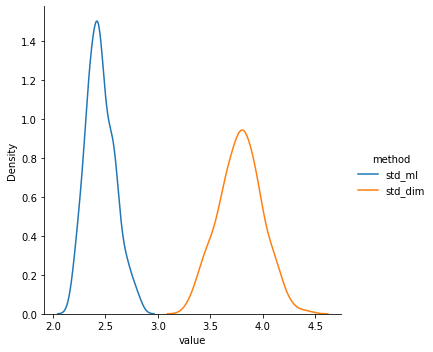

In [18]:
df_sns = final_results[['std_ml', 'std_dim']]
df_table_sns = pd.melt(df_sns, var_name = 'method')
sns.displot(df_table_sns, x='value', hue='method', kind='kde')

print(f'Average Standard Error of MLRATE is {std_ml.mean()}, Difference in Means is {std_di.mean()}')